In [1]:
'''
from tensorflow import keras
from keras import models
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import os
from PIL import Image
import cv2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.patches as patches
'''

'\nfrom tensorflow import keras\nfrom keras import models\nfrom keras import layers\nfrom keras.models import Sequential, load_model\nfrom keras.layers import Dense, Dropout\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\n%matplotlib inline\nimport seaborn as sns\nfrom collections import Counter\nimport os\nfrom PIL import Image\nimport cv2\nimport random\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\nfrom tensorflow.keras.utils import to_categorical\nfrom sklearn.model_selection import train_test_split\n\nfrom sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef\nfrom sklearn.metrics import confusion_matrix\nfrom sklearn.metrics import classification_report\nfrom tensorflow.keras.preprocessing.image import img_to_array\nimport matplotlib.patches as patches\n'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import matplotlib.patches as patches
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
import pickle
import cvlib as cv
from cvlib.object_detection import draw_bbox
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

main_directory = os.getcwd()
train_directory = main_directory + '/' + 'Train'
test_directory = main_directory + '/' + 'Test'

In [3]:
train.head(7)

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId   
0     27      26       5       5      22      20       20  \
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   
5     31      27       6       5      26      22       20   
6     31      28       6       6      26      23       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  
5  Train/20/00020_00000_00005.png  
6  Train/20/00020_00000_00006.png

In [4]:
sorted_train = train.sort_values(by='ClassId')
sorted_train

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId   
426       30      30       5       5      25      25        0  \
494       70      74       7       7      64      68        0   
495       72      75       7       6      65      68        0   
496       74      79       7       7      68      72        0   
497       74      80       6       8      67      73        0   
...      ...     ...     ...     ...     ...     ...      ...   
39053     40      43       5       6      35      38       42   
39054     42      44       5       5      37      39       42   
39055     45      47       6       6      40      42       42   
39087     68      71       6       6      62      65       42   
39208     68      69       7       6      62      63       42   

                                 Path  
426     Train/0/00000_00002_00006.png  
494     Train/0/00000_00004_00014.png  
495     Train/0/00000_00004_00015.png  
496     Train/0/00000_00004_00016.png  
497     Train/0/00000_00004_00017.png  
...                               ...  
39053  Train/42/00042_00002_00024.png  
39054  Train/42/00042_00002_00025.png  
39055  Train/42/00042_00002_00026.png  
39087  Train/42/00042_00003_00028.png  
39208  Train/42/00042_00007_00029.png  

[39209 rows x 8 columns]

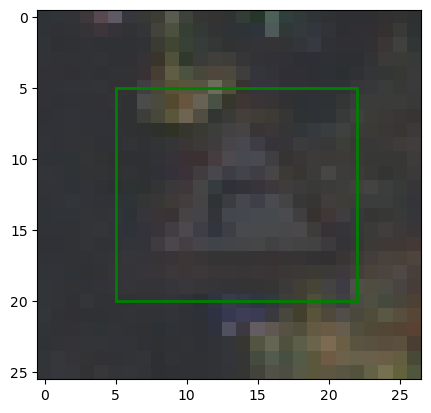

In [5]:
# Get the image path and ROI coordinates
image_path = train['Path'].iloc[0]
roi_x1 = train['Roi.X1'].iloc[0]
roi_y1 = train['Roi.Y1'].iloc[0]
roi_x2 = train['Roi.X2'].iloc[0]
roi_y2 = train['Roi.Y2'].iloc[0]

# Load the image
image = Image.open(image_path)

# Create a figure and subplot
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Create a rectangle patch for the ROI
roi_width = roi_x2 - roi_x1
roi_height = roi_y2 - roi_y1
rect = patches.Rectangle((roi_x1, roi_y1), roi_width, roi_height, linewidth=2, edgecolor='g', facecolor='none')

# Add the ROI rectangle to the plot
ax.add_patch(rect)

# Show the plot
plt.show()

# Plot the Number of images

In [6]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

NUM_CATEGORIES = len(classes)

In [7]:
numImages = {}
for i in range(0, NUM_CATEGORIES):
    numImages[i] = len(sorted_train[sorted_train['ClassId'] == i])
numImages

{0: 210,
 1: 2220,
 2: 2250,
 3: 1410,
 4: 1980,
 5: 1860,
 6: 420,
 7: 1440,
 8: 1410,
 9: 1470,
 10: 2010,
 11: 1320,
 12: 2100,
 13: 2160,
 14: 780,
 15: 630,
 16: 420,
 17: 1110,
 18: 1200,
 19: 210,
 20: 360,
 21: 330,
 22: 390,
 23: 510,
 24: 270,
 25: 1500,
 26: 600,
 27: 240,
 28: 540,
 29: 270,
 30: 450,
 31: 780,
 32: 240,
 33: 689,
 34: 420,
 35: 1200,
 36: 390,
 37: 210,
 38: 2070,
 39: 300,
 40: 360,
 41: 240,
 42: 240}

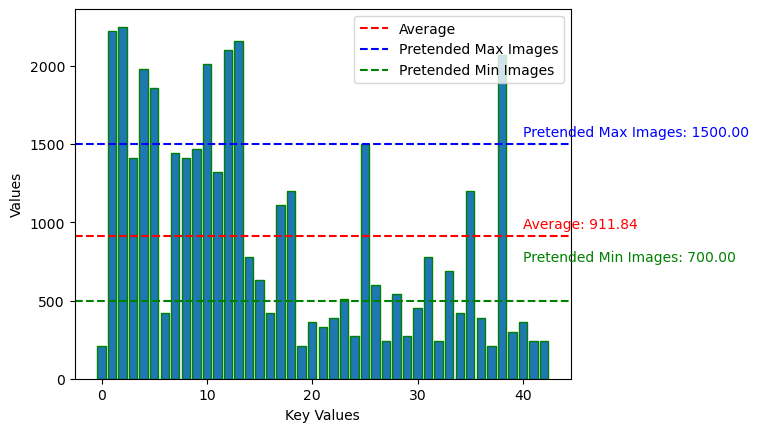

In [8]:
#Plot a histogram for the number of images per class
# Plot the histogram
plt.bar(numImages.keys(), numImages.values(), edgecolor="green")

# Set the x-axis label
plt.xlabel('Key Values')

# Set the y-axis label
plt.ylabel('Values')

# Calculate the average of the values
average = np.mean(list(numImages.values()))
# Plot a horizontal line for the average
plt.axhline(average, color='r', linestyle='--', label='Average')
plt.text(40, average + 50, f"Average: {average:.2f}", color='red')
plt.axhline(1500, color='b', linestyle='--', label='Pretended Max Images')
plt.text(40, 1500 + 50, f"Pretended Max Images: {1500:.2f}", color='blue')
plt.axhline(500, color='g', linestyle='--', label='Pretended Min Images')
plt.text(40, 700 + 50, f"Pretended Min Images: {700:.2f}", color='green')

# Show the legend
plt.legend()

# Show the plot
plt.show()


# Get the Train Data

In [9]:
sorted_train = sorted_train.reset_index()
sorted_train.drop('index', axis=1, inplace=True)
sorted_train

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId   
0         30      30       5       5      25      25        0  \
1         70      74       7       7      64      68        0   
2         72      75       7       6      65      68        0   
3         74      79       7       7      68      72        0   
4         74      80       6       8      67      73        0   
...      ...     ...     ...     ...     ...     ...      ...   
39204     40      43       5       6      35      38       42   
39205     42      44       5       5      37      39       42   
39206     45      47       6       6      40      42       42   
39207     68      71       6       6      62      65       42   
39208     68      69       7       6      62      63       42   

                                 Path  
0       Train/0/00000_00002_00006.png  
1       Train/0/00000_00004_00014.png  
2       Train/0/00000_00004_00015.png  
3       Train/0/00000_00004_00016.png  
4       Train/0/00000_00004_00017.png  
...                               ...  
39204  Train/42/00042_00002_00024.png  
39205  Train/42/00042_00002_00025.png  
39206  Train/42/00042_00002_00026.png  
39207  Train/42/00042_00003_00028.png  
39208  Train/42/00042_00007_00029.png  

[39209 rows x 8 columns]

In [10]:
X_train = []
y_train= []
roi_train = []
train_paths = []
k = 0


for i in range(0, len(sorted_train)):
    train_paths.append(sorted_train['Path'].iloc[i])
    y_train.append(sorted_train['ClassId'].iloc[i])
    roi_x1, roi_y1, roi_x2, roi_y2 = sorted_train['Roi.X1'].iloc[i], sorted_train['Roi.Y1'].iloc[i], sorted_train['Roi.X2'].iloc[i], sorted_train['Roi.Y2'].iloc[i]
    # Adjust bounding box coordinates for resizing
    resized_roi_x1 = round(roi_x1 * 32 / sorted_train['Width'].iloc[i])
    resized_roi_y1 = round(roi_y1 * 32 / sorted_train['Height'].iloc[i])
    resized_roi_x2 = round(roi_x2 * 32 / sorted_train['Width'].iloc[i])
    resized_roi_y2 = round(roi_y2 * 32 / sorted_train['Height'].iloc[i])
    roi_train.append([resized_roi_x1, resized_roi_y1, resized_roi_x2, resized_roi_y2])
    if i in [1000, 5000, 10000, 20000, 30000, 35000]:
        print(i)
    
for path in train_paths:
    try: 
        image = cv2.imread(path)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((32, 32))
        image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
        X_train.append(np.array(image))
        if k in [1000, 5000, 10000, 20000, 30000, 35000]:
            print(k)
        k+=1
    
    except:
        print("Error in " + path)

    


1000
5000
10000
20000
30000
35000
1000
5000
10000
20000
30000
35000


In [11]:
X_train = np.array(X_train)/255
y_train = np.array(y_train)
roi_train = np.array(roi_train)
#One Hot Encoding
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)

print(X_train.shape)
print(y_train.shape)
print(roi_train.shape)

(39209, 32, 32, 3)
(39209, 43)
(39209, 4)


# Data Augmentation (Remove images from overpopulated classes)

In [12]:
# Count the number of images per label
label_counter = defaultdict(int)
for label in np.argmax(y_train, axis=1):
    label_counter[label] += 1

# Create a sorted dictionary of label counts
sorted_label_counts = dict(sorted(label_counter.items()))

In [13]:
# Determine the most populated labels
most_populated_labels = sorted(sorted_label_counts, key=label_counter.get, reverse=True)

# Create a balanced dataset with a maximum of 1500 images per label
balanced_X_train = []
balanced_y_train = []
max_images_per_label = 1500

new_label_counts = {}

for label in most_populated_labels:
    label_indices = np.where(np.argmax(y_train, axis=1) == label)[0]
    np.random.shuffle(label_indices)
    selected_indices = label_indices[:max_images_per_label]
    balanced_X_train.extend(X_train[selected_indices])
    balanced_y_train.extend(y_train[selected_indices])
    
    new_label_counts[label] = len(selected_indices)

# Convert balanced datasets to numpy arrays
X_train = np.array(balanced_X_train)
y_train = np.array(balanced_y_train)

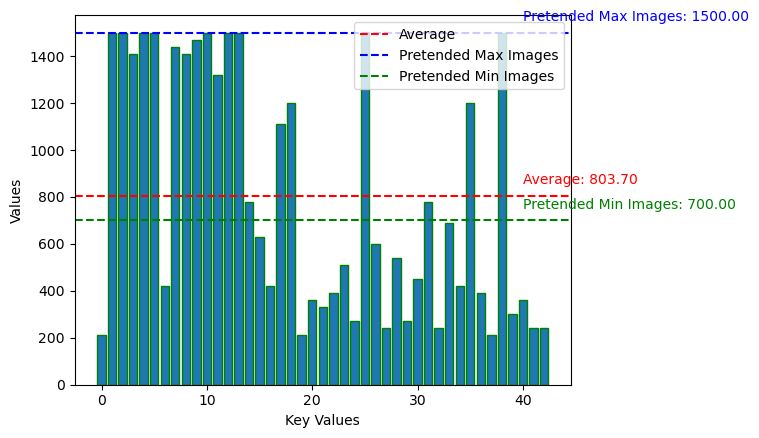

In [14]:
#Plot a histogram for the number of images per class
# Plot the histogram
plt.bar(new_label_counts.keys(), new_label_counts.values(), edgecolor="green")

# Set the x-axis label
plt.xlabel('Key Values')

# Set the y-axis label
plt.ylabel('Values')

# Calculate the average of the values
average = np.mean(list(new_label_counts.values()))
# Plot a horizontal line for the average
plt.axhline(average, color='r', linestyle='--', label='Average')
plt.text(40, average + 50, f"Average: {average:.2f}", color='red')
plt.axhline(1500, color='b', linestyle='--', label='Pretended Max Images')
plt.text(40, 1500 + 50, f"Pretended Max Images: {1500:.2f}", color='blue')
plt.axhline(700, color='g', linestyle='--', label='Pretended Min Images')
plt.text(40, 700 + 50, f"Pretended Min Images: {700:.2f}", color='green')

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [15]:
new_label_counts

{2: 1500,
 1: 1500,
 13: 1500,
 12: 1500,
 38: 1500,
 10: 1500,
 4: 1500,
 5: 1500,
 25: 1500,
 9: 1470,
 7: 1440,
 3: 1410,
 8: 1410,
 11: 1320,
 18: 1200,
 35: 1200,
 17: 1110,
 14: 780,
 31: 780,
 33: 689,
 15: 630,
 26: 600,
 28: 540,
 23: 510,
 30: 450,
 6: 420,
 16: 420,
 34: 420,
 22: 390,
 36: 390,
 20: 360,
 40: 360,
 21: 330,
 39: 300,
 24: 270,
 29: 270,
 27: 240,
 32: 240,
 41: 240,
 42: 240,
 0: 210,
 19: 210,
 37: 210}

# Data Augmentation (Add images from less populated classes)

In [ ]:
'''
# Create an empty list for balanced dataset
balanced_X_train = []
balanced_y_train = []

# Minimum images per label
min_images_per_label = 700

# Create ImageDataGenerator for augmentation
datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1)

for label, count in new_label_counts.items():
    label_indices = np.where(np.argmax(y_train, axis=1) == label)[0]
    num_existing_images = count
    num_new_images = min_images_per_label - num_existing_images
    
    # Add new images to reach minimum count
    if num_new_images > 0:
        selected_indices = np.random.choice(label_indices, size=num_new_images, replace=True)
        for index in selected_indices:
            image = X_train[index]
            image = np.expand_dims(image, axis=0)
            augmented_images = datagen.flow(image, batch_size=1)
            for _ in range(num_new_images):
                augmented_image = augmented_images.next()[0]
                balanced_X_train.append(augmented_image)
                balanced_y_train.append(y_train[index])
    
    new_label_counts[label] += num_new_images

# Convert balanced datasets to numpy arrays
X_train = np.array(balanced_X_train)
y_train = np.array(balanced_y_train)

# Check the updated label counts
print(new_label_counts)
'''



In [ ]:
'''
# Plot a histogram of the updated label counts
plt.bar(new_label_counts.keys(), new_label_counts.values())
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.title('Updated Label Counts')
plt.show()
'''

# Get Test Data

In [16]:
sorted_test = test.sort_values(by='ClassId')
sorted_test = sorted_test.reset_index()
sorted_test.drop('index', axis=1, inplace=True)
sorted_test

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0         49      51       6       5      44      46        0  Test/05945.png
1         31      33       6       6      25      28        0  Test/07712.png
2         45      49       5       5      40      44        0  Test/00807.png
3         32      31       6       5      27      26        0  Test/00809.png
4         31      34       5       5      26      29        0  Test/04512.png
...      ...     ...     ...     ...     ...     ...      ...             ...
12625     32      33       5       5      26      27       42  Test/04496.png
12626     27      28       6       5      22      23       42  Test/09593.png
12627     41      43       6       6      36      38       42  Test/11842.png
12628     49      53       6       5      44      48       42  Test/05786.png
12629     31      33       5       6      25      28       42  Test/06668.png

[12630 rows x 8 columns]

In [17]:
X_test = []
y_test= []
roi_test = []
test_paths = []

for i in range(0, len(sorted_test)):
    test_paths.append(sorted_test['Path'].iloc[i])
    y_test.append(sorted_test['ClassId'].iloc[i])
    roi_x1, roi_y1, roi_x2, roi_y2 = sorted_test['Roi.X1'].iloc[i], sorted_test['Roi.Y1'].iloc[i], sorted_test['Roi.X2'].iloc[i], sorted_test['Roi.Y2'].iloc[i]
    # Adjust bounding box coordinates for resizing
    resized_roi_x1 = round(roi_x1 * 32 / sorted_test['Width'].iloc[i])
    resized_roi_y1 = round(roi_y1 * 32 / sorted_test['Height'].iloc[i])
    resized_roi_x2 = round(roi_x2 * 32 / sorted_test['Width'].iloc[i])
    resized_roi_y2 = round(roi_y2 * 32 / sorted_test['Height'].iloc[i])
    roi_test.append([resized_roi_x1, resized_roi_y1, resized_roi_x2, resized_roi_y2])

for path in test_paths:
    try:
        image = cv2.imread(path) #Gets the image in array shape
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Change back to RGB
        image = Image.fromarray(image, 'RGB')
        image = image.resize((32, 32))
        image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
        X_test.append(np.array(image))
        
        
    except:
        print("Error in " + path)

In [18]:
X_test = np.array(X_test)/255
y_test = np.array(y_test)
roi_test = np.array(roi_test)
#One Hot Encoding
y_test = keras.utils.to_categorical(y_test, NUM_CATEGORIES)


print(X_test.shape)
print(y_test.shape)
print(roi_test.shape)

(12630, 32, 32, 3)
(12630, 43)
(12630, 4)


# Model

In [19]:
#SHUFFLE THE DATA THE SAME WAY
# Generate a random permutation of indices
indices = np.random.permutation(len(X_train))

# Shuffle both arrays using the same indices
X_train = X_train[indices]
y_train = y_train[indices]
roi_train = roi_train[indices]

In [23]:
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout
from keras.models import Model
from keras import Input

# Define the input layer
input_layer = Input(shape=(32, 32, 3))

# Define the model architecture
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(input_layer)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)

# Add branches for label and ROI predictions
label_output = Dense(43, activation='softmax', name='label_output')(x)
roi_output = Dense(4, activation='linear', name='roi_output')(x)

# Create a model with both label and ROI outputs
model = Model(inputs=input_layer, outputs=[label_output, roi_output])


In [24]:
model.compile(optimizer='adam',
              loss={'label_output': 'categorical_crossentropy', 'roi_output': 'mean_squared_error'},
              metrics={'label_output': 'accuracy', 'roi_output': 'mean_squared_error'})

In [25]:
# Train the model and store the history
history = model.fit(X_train, {'label_output': y_train, 'roi_output': roi_train}, epochs=30, batch_size=32, validation_split=0.2)
with open('kaggleHistory.pickle', 'wb') as f:
    pickle.dump(history.history, f)
model.save('kaggleModel.h5')

Epoch 1/30
864/864 [==============================] - 35s 39ms/step - loss: 82.5607 - label_output_loss: 3.4221 - roi_output_loss: 79.1388 - label_output_accuracy: 0.1571 - roi_output_mean_squared_error: 79.1388 - val_loss: 4.2793 - val_label_output_loss: 2.3219 - val_roi_output_loss: 1.9574 - val_label_output_accuracy: 0.3385 - val_roi_output_mean_squared_error: 1.9574
Epoch 2/30
864/864 [==============================] - 34s 40ms/step - loss: 9.0273 - label_output_loss: 2.1385 - roi_output_loss: 6.8888 - label_output_accuracy: 0.3664 - roi_output_mean_squared_error: 6.8888 - val_loss: 3.2999 - val_label_output_loss: 1.6058 - val_roi_output_loss: 1.6941 - val_label_output_accuracy: 0.5253 - val_roi_output_mean_squared_error: 1.6941
Epoch 3/30
864/864 [==============================] - 36s 42ms/step - loss: 6.5524 - label_output_loss: 1.4102 - roi_output_loss: 5.1422 - label_output_accuracy: 0.5538 - roi_output_mean_squared_error: 5.1422 - val_loss: 2.2264 - val_label_output_loss: 0.80

In [20]:
# Load model history from file
with open('kaggleHistory.pickle', 'rb') as f:
    history = pickle.load(f)
    
model = load_model("kaggleModel.h5")  

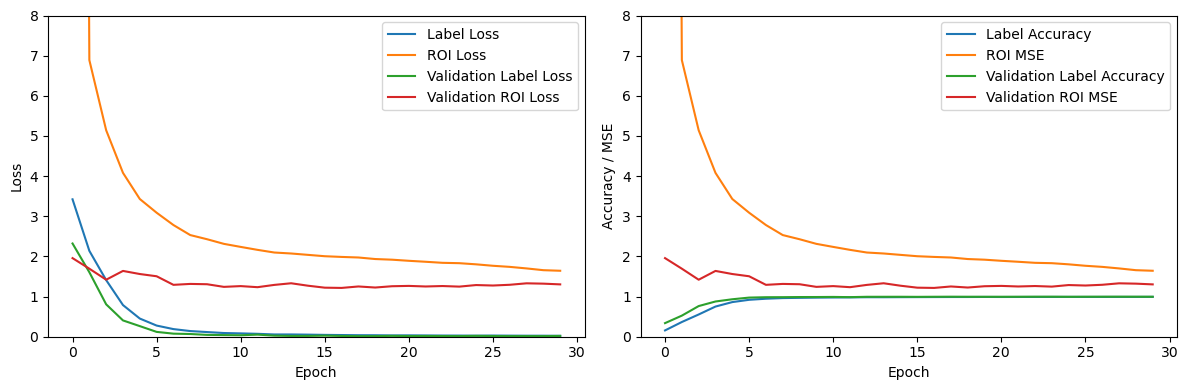

In [21]:
# Get the loss and accuracy values from the history object
label_loss = history['label_output_loss']
roi_loss = history['roi_output_loss']
label_acc = history['label_output_accuracy']
roi_mse = history['roi_output_mean_squared_error']
val_label_loss = history['val_label_output_loss']
val_roi_loss = history['val_roi_output_loss']
val_label_acc = history['val_label_output_accuracy']
val_roi_mse = history['val_roi_output_mean_squared_error']

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(label_loss, label='Label Loss')
plt.plot(roi_loss, label='ROI Loss')
plt.plot(val_label_loss, label='Validation Label Loss')
plt.plot(val_roi_loss, label='Validation ROI Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 8])  # Set the y-axis limits
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(label_acc, label='Label Accuracy')
plt.plot(roi_mse, label='ROI MSE')
plt.plot(val_label_acc, label='Validation Label Accuracy')
plt.plot(val_roi_mse, label='Validation ROI MSE')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / MSE')
plt.ylim([0, 8])  # Set the y-axis limits
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Evaluate the model on the test data
test_results = model.evaluate([X_test], {'label_output': y_test, 'roi_output': roi_test})

395/395 [==============================] - 4s 9ms/step - loss: 1.5162 - label_output_loss: 0.0883 - roi_output_loss: 1.4279 - label_output_accuracy: 0.9782 - roi_output_mean_squared_error: 1.4279


In [23]:
# Get the metric names
metric_names = model.metrics_names

# Create a dictionary with the test results
test_results_dict = {
    "Metric": metric_names,
    "Value": test_results
}

# Create a DataFrame
df = pd.DataFrame(test_results_dict)

# Print the DataFrame
df

Metric     Value
0                           loss  1.516218
1              label_output_loss  0.088304
2                roi_output_loss  1.427914
3          label_output_accuracy  0.978226
4  roi_output_mean_squared_error  1.427914

1/1 [==============================] - 0s 15ms/step


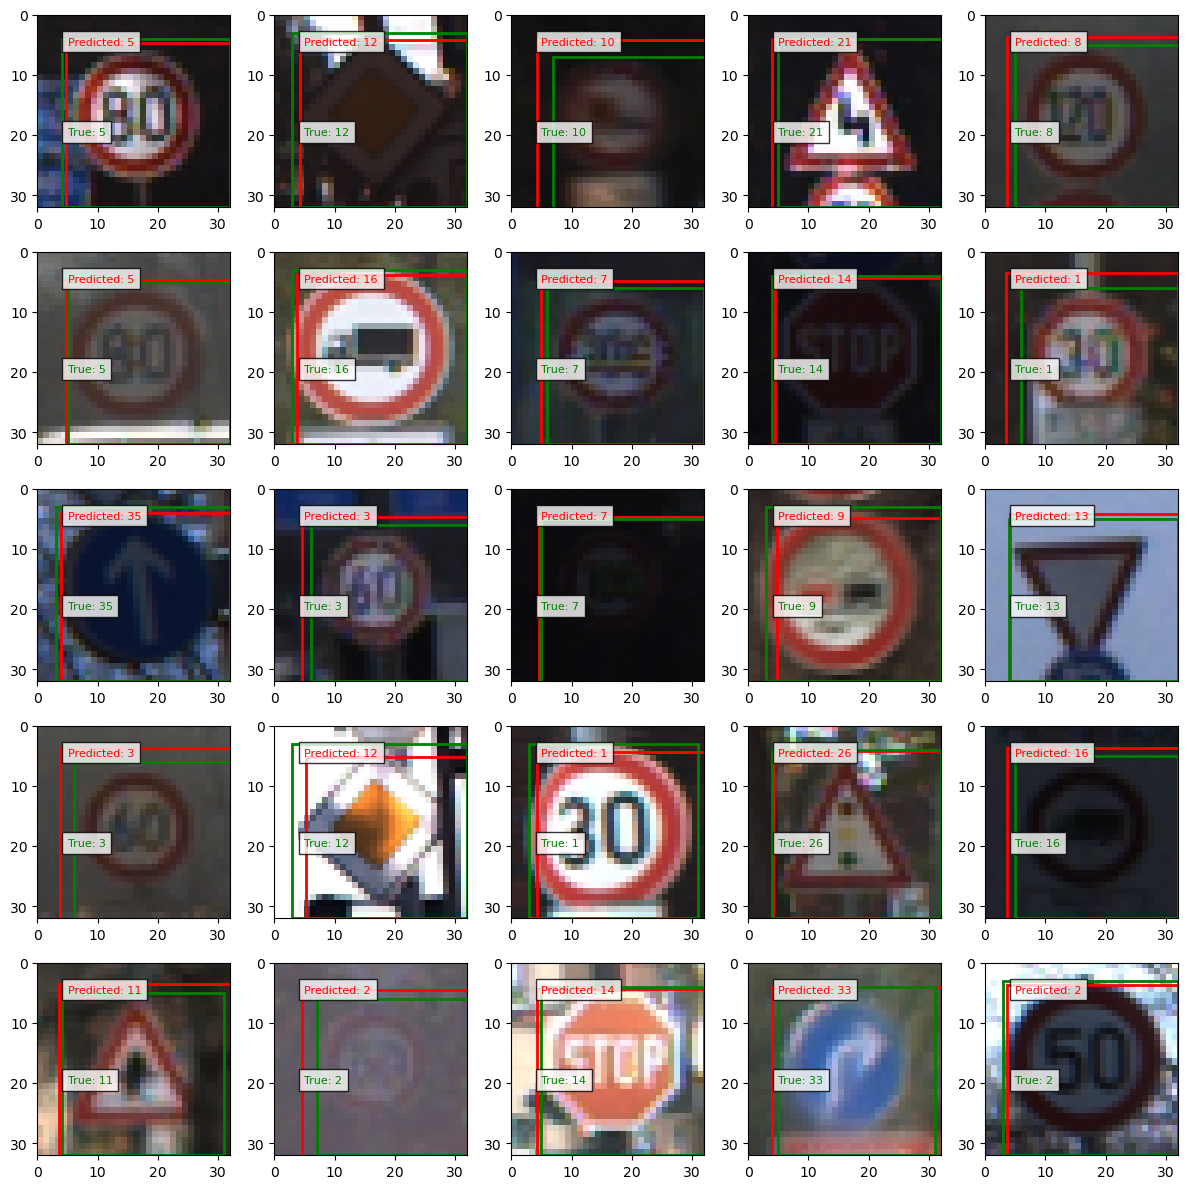

In [24]:
# Select 25 random indices
random_indices = np.random.choice(len(X_test), size=25, replace=False)

# Create a 5x5 grid for subplots
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = axes.ravel()

for i, index in enumerate(random_indices):
    image = X_test[index]
    image = image.reshape((1,) + image.shape)  # Reshape the image for prediction
    label_prediction, roi_prediction = model.predict([image])

    true_label = np.argmax(y_test[index])
    true_roi = roi_test[index]
    
    #print(true_roi)
    
    # Plot the image with pixel values in the x and y axes
    axes[i].imshow(image[0], extent=[0, image.shape[2], image.shape[1], 0])
    axes[i].axis('on')

    # Add a rectangle representing the predicted ROI
    roi_x, roi_y, roi_width, roi_height = roi_prediction[0]
    pred_rect = plt.Rectangle((roi_x, roi_y), roi_width, roi_height,
                              fill=False, color='r', linewidth=2)
    axes[i].add_patch(pred_rect)

    # Add a rectangle representing the true ROI
    true_roi_x, true_roi_y, true_roi_width, true_roi_height = true_roi
    true_rect = plt.Rectangle((true_roi_x, true_roi_y), true_roi_width, true_roi_height,
                              fill=False, color='g', linewidth=2)
    axes[i].add_patch(true_rect)

    # Add the predicted label text
    predicted_class = np.argmax(label_prediction)
    predicted_label_text = f"Predicted: {predicted_class}"
    axes[i].text(5, 5, predicted_label_text, color='r', fontsize=8, bbox=dict(facecolor='white', alpha=0.8))

    # Add the true label text
    true_label_text = f"True: {true_label}"
    axes[i].text(5, 20, true_label_text, color='g', fontsize=8, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

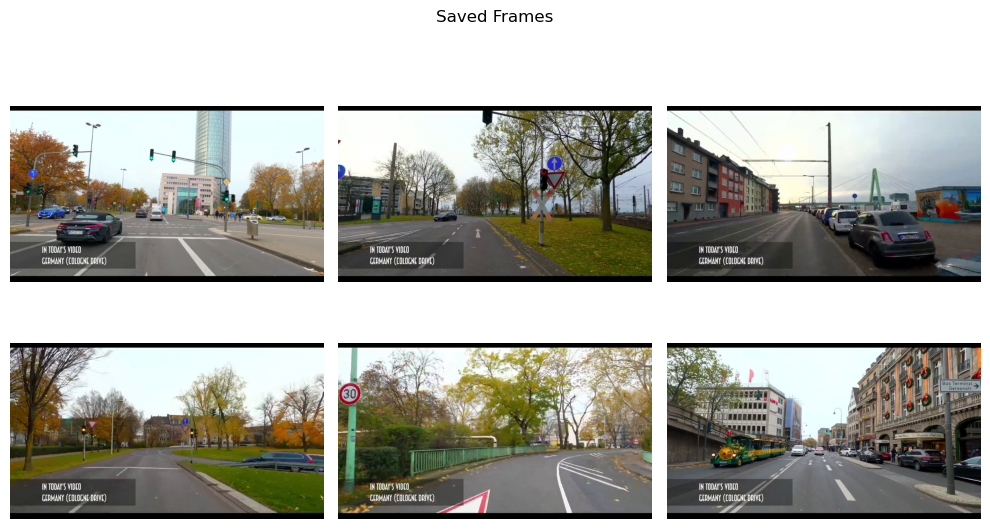

In [30]:
# Path to the video file
video_path = 'optut7.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video file was successfully opened
if not cap.isOpened():
    print("Error opening video file")
    exit()

# Frame indices to save
frame_indices = [100, 200, 300, 400, 500, 600]

# List to store the saved frames
saved_frames = []

# Read and save frames from the video file
for index in frame_indices:
    # Set the frame position to the desired index
    cap.set(cv2.CAP_PROP_POS_FRAMES, index)

    # Read the frame
    ret, frame = cap.read()

    # Check if the frame was successfully read
    if not ret:
        print(f"Error reading frame at index {index}")
        continue

    # Append the frame to the list
    saved_frames.append(frame)

# Release the video file
cap.release()

# Plot the saved frames
num_frames = len(saved_frames)
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
fig.suptitle('Saved Frames')

for i in range(num_frames):
    ax = axes[i // 3, i % 3]
    ax.imshow(cv2.cvtColor(saved_frames[i], cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.tight_layout()
plt.show()

C:\Users\Msi\AppData\Local\Temp\ipykernel_8448\246485927.py:62: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


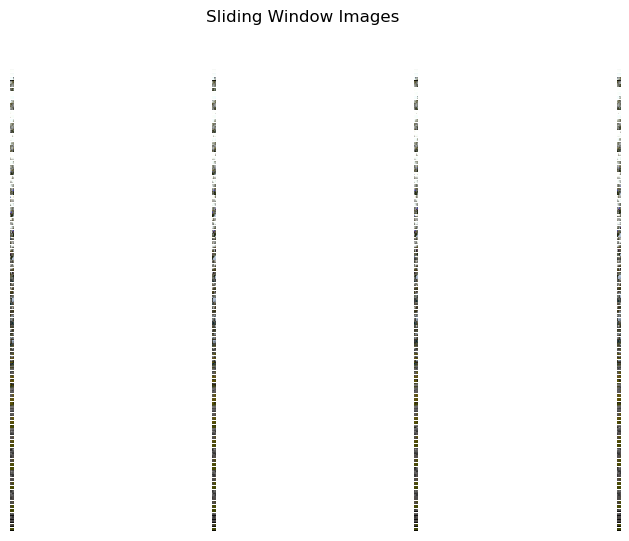

In [102]:
# Path to the video file
video_path = 'optut7.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video file was successfully opened
if not cap.isOpened():
    print("Error opening video file")
    exit()

# Index of the frame to process
frame_index = 200

# Read the frame at the specified index
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
ret, frame = cap.read()

# Check if the frame was successfully read
if not ret:
    print(f"Error reading frame at index {frame_index}")
    exit()

# Resizing parameters
resized_frame_size = (400, 400)

# Resize the frame to the desired size
resized_frame = cv2.resize(frame, resized_frame_size)

# Sliding window parameters
window_size = 64
stride = 16

# List to store the resulting images
sliding_window_images = []

# Generate the sliding windows and extract images
for y in range(0, resized_frame_size[1] - window_size + 1, stride):
    for x in range(0, resized_frame_size[0] - window_size + 1, stride):
        # Extract the window from the resized frame
        window = resized_frame[y:y+window_size, x:x+window_size]

        # Append the window to the list
        sliding_window_images.append(window)

# Release the video file
cap.release()

# Plot the sliding window images
num_windows = len(sliding_window_images)
num_cols = 4
num_rows = (num_windows + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))
fig.suptitle('Sliding Window Images')

for i in range(num_windows):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(cv2.cvtColor(sliding_window_images[i], cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [103]:
len(sliding_window_images)

484

1/1 [==============================] - 0s 14ms/step


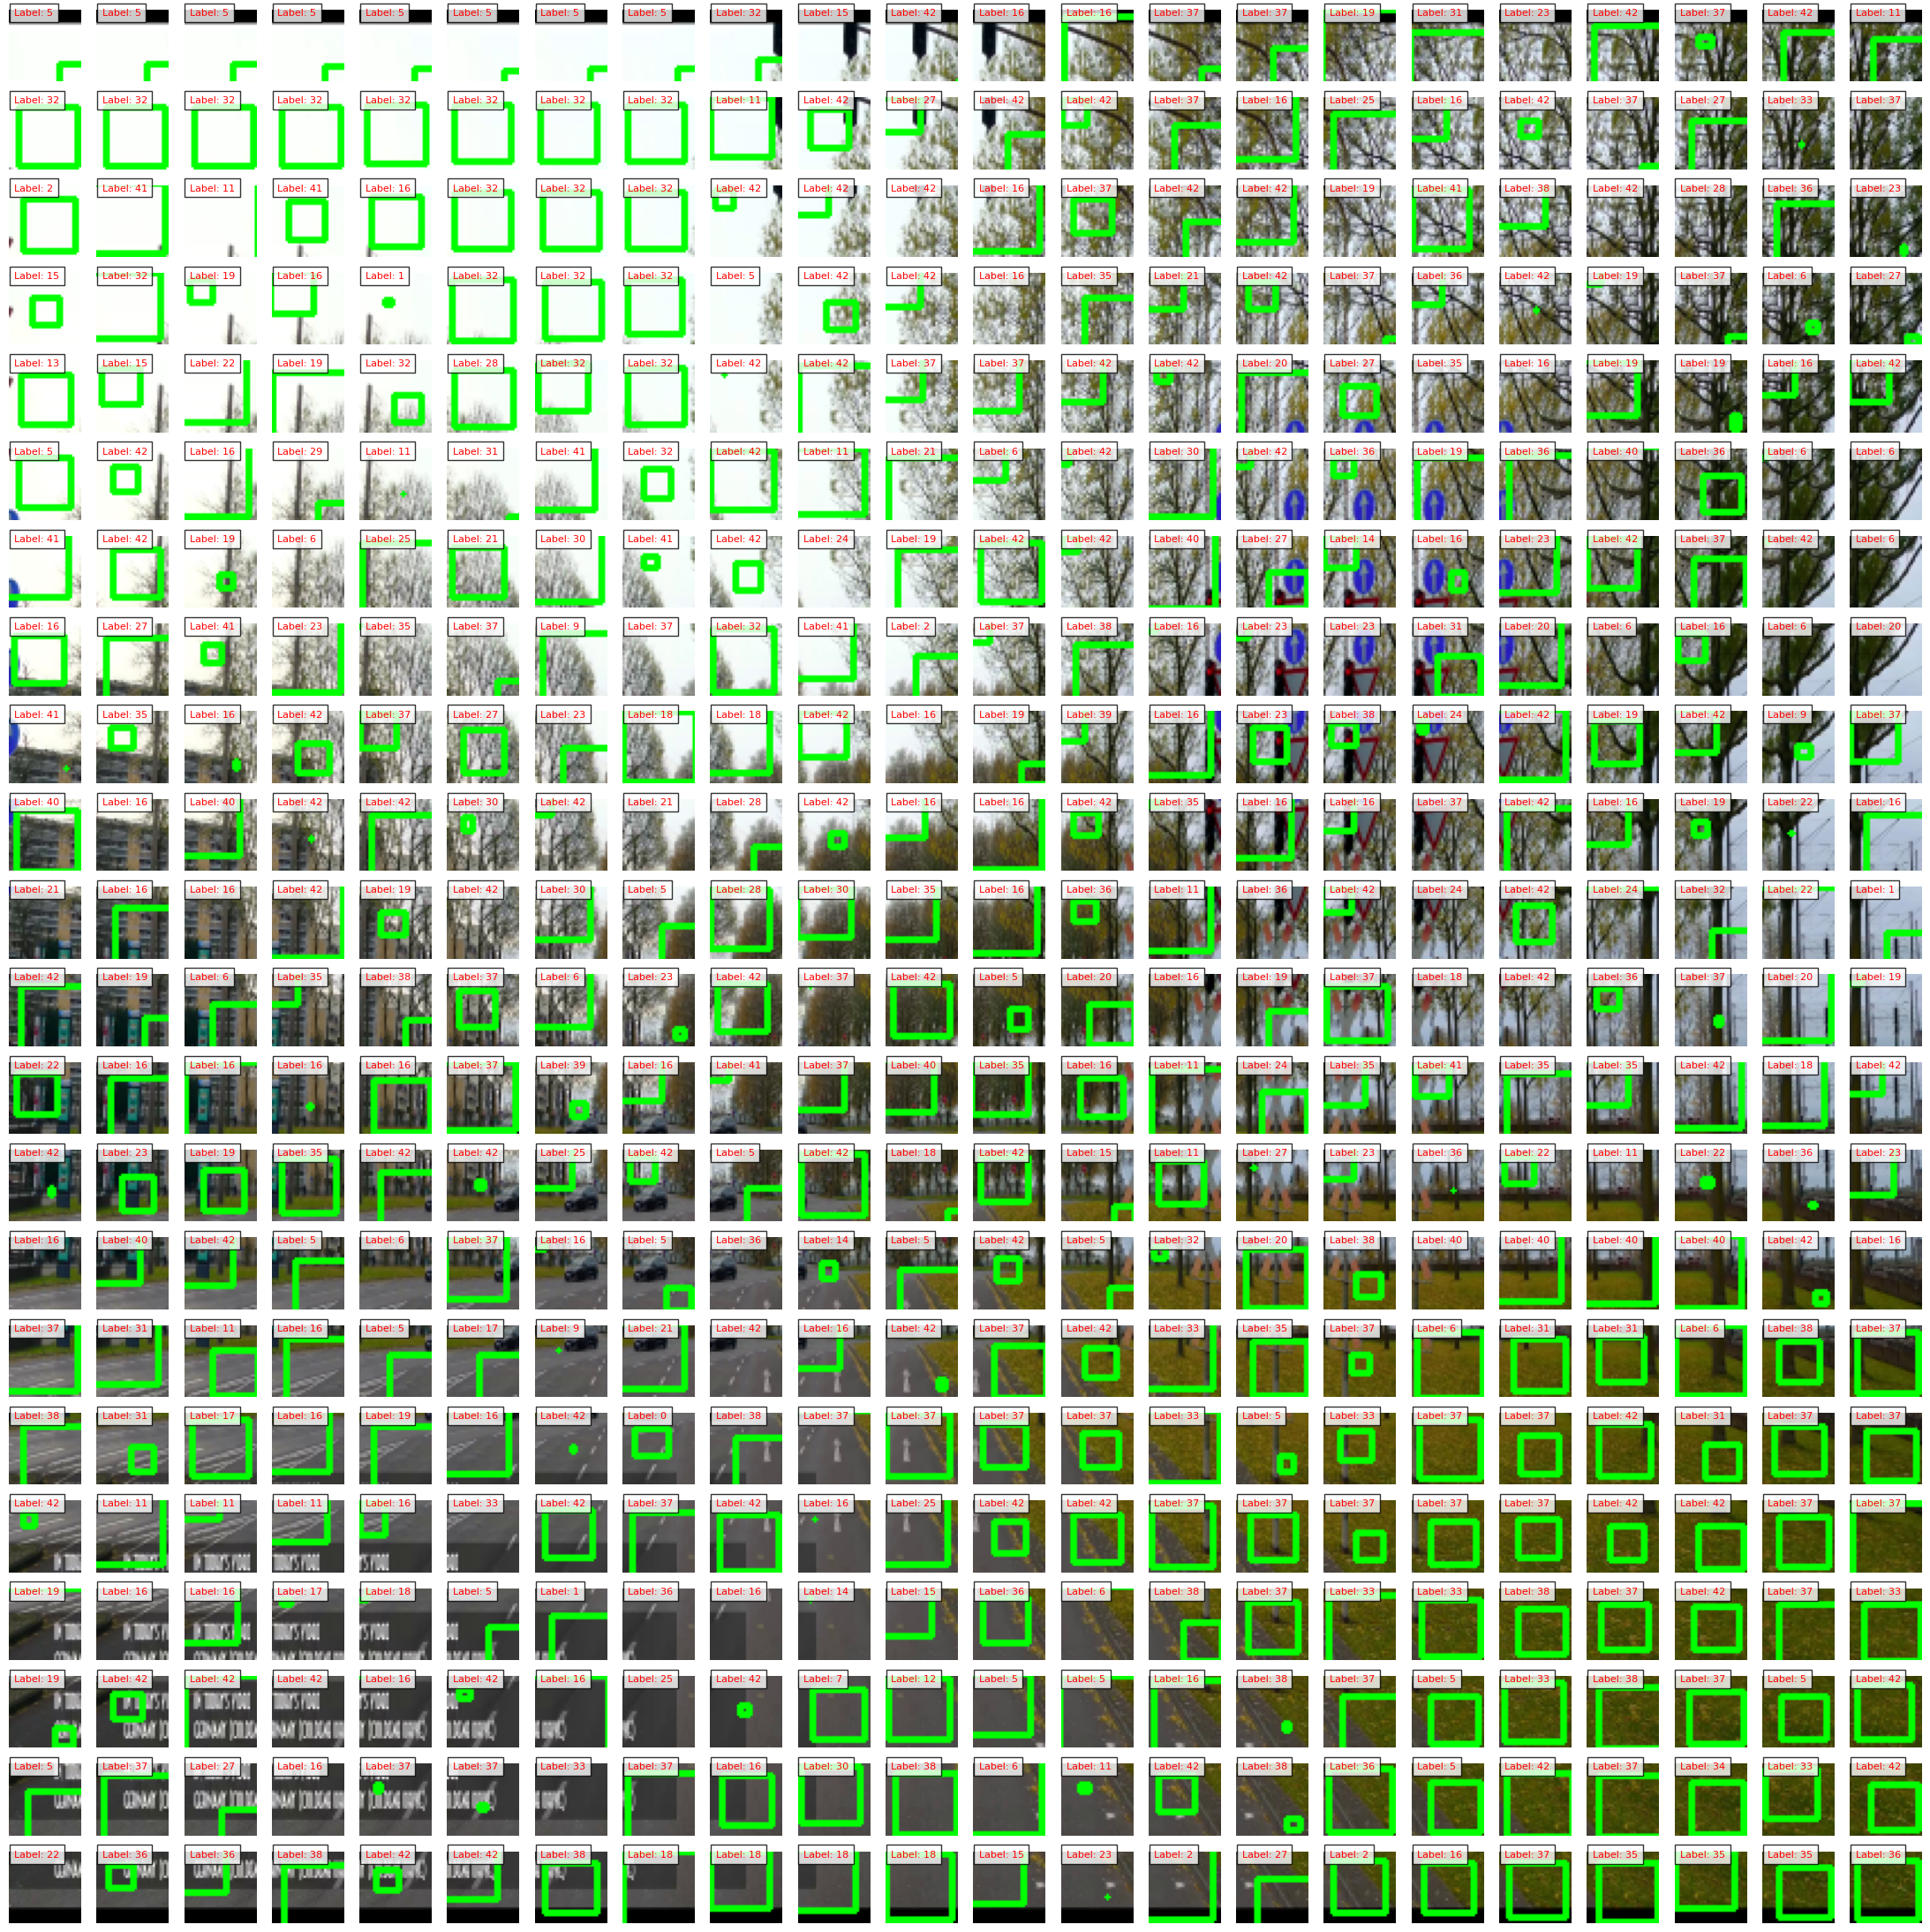

In [105]:
# Calculate the number of rows and columns for the grid
num_rows = 22
num_cols = 22

# Create a figure and axes for the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(22, 22))

# Iterate over the sliding window images and plot them in the grid
for i in range(len(sliding_window_images)):
    # Calculate the row and column index for the current image
    row_index = i // num_cols
    col_index = i % num_cols
    
    # Get the current axes object for the image
    ax = axes[row_index, col_index]
    
    # Resize the image to match the model input shape
    resized_image = cv2.resize(sliding_window_images[i], (32, 32))
    
    # Expand dimensions to create a batch of size 1
    input_image = np.expand_dims(resized_image, axis=0)
    
    # Perform classification using your CNN model
    predictions = model.predict(input_image)
    
    # Get the predicted class label and ROI
    class_label = np.argmax(predictions[0])
    roi = predictions[1][0]
    
    # Draw the ROI on the resized image
    x, y, width, height = map(int, roi)
    roi_image = cv2.rectangle(resized_image, (x, y), (x + width, y + height), (0, 255, 0), 2)
    
    # Plot the image with ROI and label
    ax.imshow(cv2.cvtColor(roi_image, cv2.COLOR_BGR2RGB))
    ax.text(2, 2, f'Label: {class_label}', color='r', fontsize=8, bbox=dict(facecolor='white', alpha=0.8))
    ax.axis('off')

# Remove any empty subplot axes
if len(sliding_window_images) < num_rows * num_cols:
    for i in range(len(sliding_window_images), num_rows * num_cols):
        ax = axes[i // num_cols, i % num_cols]
        ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the grid of images
plt.show()

In [101]:
predictions

[array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         1.3470864e-28, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 3.8591241e-09, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 4.2058454e-27, 0.0000000e+00,
         1.0000000e+00, 0.0000000e+00, 1.8034533e-36, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]], dtype=float32),
 array([[-5.115709, -4.202422, 25.040405, 24.108667]], dtype=float32)]

1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 27ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 33ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


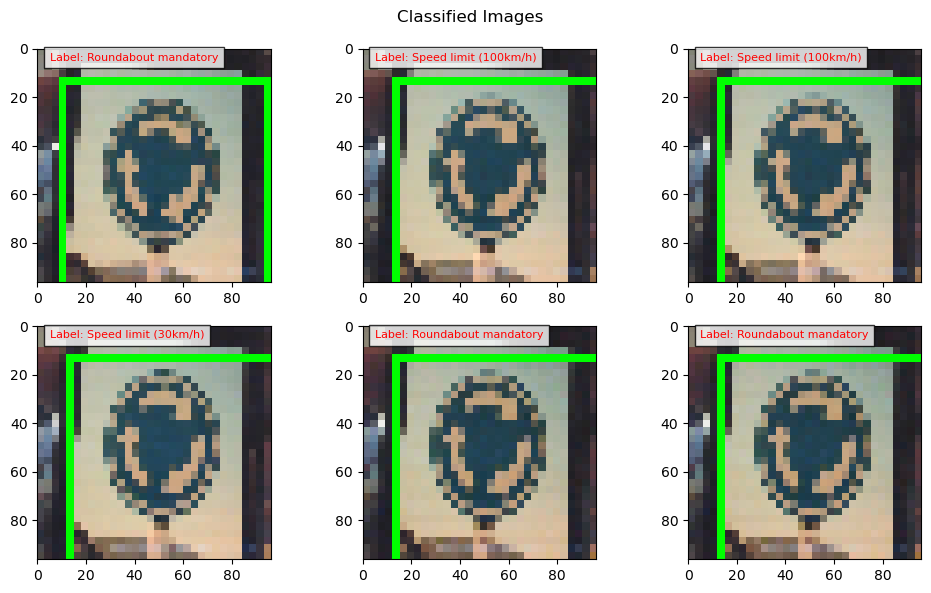

In [71]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Set up the webcam
cap = cv2.VideoCapture(0)

# Initialize a list to store the classified images
classified_images = []

# Initialize a counter to keep track of saved frames
frame_counter = 0

# Save 6 frames and classify them
while frame_counter < 6:
    # Read frame from the webcam
    ret, frame = cap.read()

    # Convert color space from BGR to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Resize the frame to 96x96
    resized_frame = cv2.resize(frame, (32, 32))

    # Normalize the resized frame
    normalized_frame = resized_frame / 255.0

    # Append the normalized image to the array
    classified_images.append(normalized_frame)

    # Increment the frame counter
    frame_counter += 1

# Release the webcam
cap.release()

# Perform classification on the images, draw ROI, and plot the results
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
fig.suptitle('Classified Images')

for i, image in enumerate(classified_images):
    ax = axes[i // 3, i % 3]

    # Perform classification on the image
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    confidence_values = prediction[0][0]
    predicted_class = np.argmax(confidence_values)
    label = classes[predicted_class]

    # Get the predicted ROI
    predicted_roi = prediction[1][0]
    x, y, width, height = map(int, predicted_roi)

    # Draw the ROI on the image
    roi_image = cv2.rectangle(image[0], (x, y), (x + width, y + height), (0, 255, 0), 1)

    # Plot the image with ROI and label
    ax.imshow(roi_image, extent=[0, 96, 96, 0])
    ax.text(5, 5, f'Label: {label}', color='r', fontsize=8, bbox=dict(facecolor='white', alpha=0.8))
    ax.axis('on')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


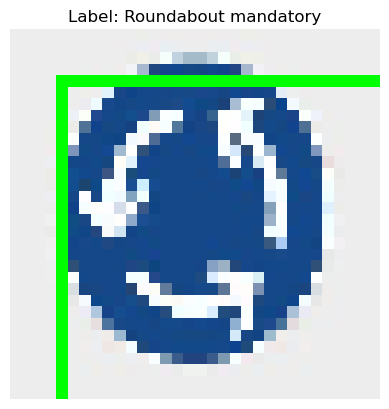

In [73]:
# Read the image from the provided path
image_path = main_directory + '/Screenshot_1.jpg'
image = cv2.imread(image_path)

# Convert color space from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize the image to 32x32
resized_image = cv2.resize(image, (32, 32))

# Normalize the resized image
normalized_image = resized_image / 255.0

# Perform classification on the image
image = np.expand_dims(normalized_image, axis=0)
prediction = model.predict(image)
confidence_values = prediction[0][0]
predicted_class = np.argmax(confidence_values)
label = classes[predicted_class]

# Get the predicted ROI
predicted_roi = prediction[1][0]
x, y, width, height = map(int, predicted_roi)

# Draw the ROI on the image
roi_image = cv2.rectangle(image[0], (x, y), (x + width, y + height), (0, 255, 0), 1)

# Display the image with ROI and label
plt.imshow(roi_image)
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 23ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


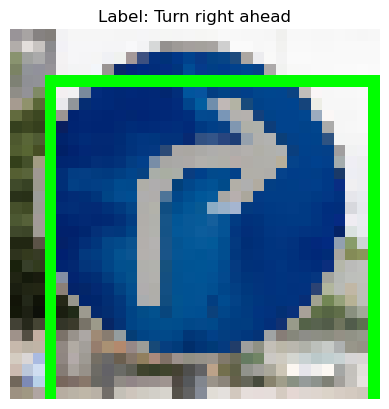

In [110]:
# Read the image from the provided path
image_path = main_directory + '/Screenshot_2.jpg'
image = cv2.imread(image_path)

# Convert color space from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize the image to 32x32
resized_image = cv2.resize(image, (32, 32))

# Normalize the resized image
normalized_image = resized_image / 255.0

# Perform classification on the image
image = np.expand_dims(normalized_image, axis=0)
prediction = model.predict(image)
confidence_values = prediction[0][0]
predicted_class = np.argmax(confidence_values)
label = classes[predicted_class]

# Get the predicted ROI
predicted_roi = prediction[1][0]
x, y, width, height = map(int, predicted_roi)

# Draw the ROI on the image
roi_image = cv2.rectangle(image[0], (x, y), (x + width, y + height), (0, 255, 0), 1)

# Display the image with ROI and label
plt.imshow(roi_image)
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


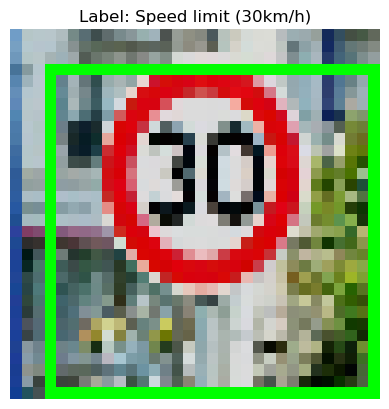

In [111]:
# Read the image from the provided path
image_path = main_directory + '/Screenshot_5.jpg'
image = cv2.imread(image_path)

# Convert color space from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize the image to 32x32
resized_image = cv2.resize(image, (32, 32))

# Normalize the resized image
normalized_image = resized_image / 255.0

# Perform classification on the image
image = np.expand_dims(normalized_image, axis=0)
prediction = model.predict(image)
confidence_values = prediction[0][0]
predicted_class = np.argmax(confidence_values)
label = classes[predicted_class]

# Get the predicted ROI
predicted_roi = prediction[1][0]
x, y, width, height = map(int, predicted_roi)

# Draw the ROI on the image
roi_image = cv2.rectangle(image[0], (x, y), (x + width, y + height), (0, 255, 0), 1)

# Display the image with ROI and label
plt.imshow(roi_image)
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

# Transfer Learning

In [ ]:
pre_trained_model1 = Sequential()
ResNet50 = keras.applications.ResNet50(
    include_top=False, #Não queremos a input layer e a output layer
    weights="imagenet",
    input_shape=(32, 32, 3),
    pooling='avg',
    classes=43)

for layer in ResNet50.layers:
    layer.trainable = False
    
pre_trained_model1.add(ResNet50)
pre_trained_model1.add(keras.layers.Flatten())
pre_trained_model1.add(keras.layers.Dense(512, activation='relu'))
pre_trained_model1.add(keras.layers.BatchNormalization())
pre_trained_model1.add(keras.layers.Dropout(rate=0.5))
pre_trained_model1.add(keras.layers.Dense(43, activation='softmax'))

In [ ]:
lr = 0.001
epochs = 30
pre_trained_model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
pre_trained_model1.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))

# YOLO

In [ ]:
import os

train_yolo = train.copy()

# Create new columns for YOLO format
train_yolo['YOLO_XCenter'] = 0.0
train_yolo['YOLO_YCenter'] = 0.0
train_yolo['YOLO_Width'] = 0.0
train_yolo['YOLO_Height'] = 0.0

# Iterate over each row in the dataframe
for index, row in train_yolo.iterrows():
    x1 = row['Roi.X1']
    y1 = row['Roi.Y1']
    x2 = row['Roi.X2']
    y2 = row['Roi.Y2']
    width = x2 - x1
    height = y2 - y1
    x_center = (x1 + x2) / 2
    y_center = (y1 + y2) / 2
    image_width = row['Width']
    image_height = row['Height']

    # Normalize the values
    x_center_normalized = x_center / image_width
    y_center_normalized = y_center / image_height
    width_normalized = width / image_width
    height_normalized = height / image_height

    # Update the corresponding columns in the dataframe
    train_yolo.at[index, 'YOLO_XCenter'] = x_center_normalized
    train_yolo.at[index, 'YOLO_YCenter'] = y_center_normalized
    train_yolo.at[index, 'YOLO_Width'] = width_normalized
    train_yolo.at[index, 'YOLO_Height'] = height_normalized

# Update the image path in the dataframe
train_yolo['Path'] = train_yolo['Path'].apply(lambda path: os.path.join('yoloData/Images/Train', os.path.basename(path)).replace("\\", "/"))

# Print the updated dataframe
sorted_train_yolo = train_yolo.sort_values(by='Path')
sorted_train_yolo = sorted_train_yolo.reset_index(drop=True)
sorted_train_yolo

In [ ]:
# Iterate over each row in the dataframe
for index, row in sorted_train_yolo.iterrows():
    # Extract the necessary information
    class_id = row['ClassId']
    image_path = row['Path']
    yolo_x_center = row['YOLO_XCenter']
    yolo_y_center = row['YOLO_YCenter']
    yolo_width = row['YOLO_Width']
    yolo_height = row['YOLO_Height']
    
    # Create the YOLO annotation string
    yolo_annotation = f"{class_id} {yolo_x_center} {yolo_y_center} {yolo_width} {yolo_height}"
    
    # Generate the output file path
    file_name = os.path.basename(image_path)
    output_file = os.path.join("D:/MestradoEngenhariaInformatica/2_Semestre/AAA/PROJETO/yoloData/labels/train/", os.path.splitext(file_name)[0] + '.txt')
    
    # Save the YOLO annotation file
    with open(output_file, 'w') as f:
        f.write(yolo_annotation)

In [ ]:
test_yolo = test.copy()

# Create new columns for YOLO format
test_yolo['YOLO_XCenter'] = 0.0
test_yolo['YOLO_YCenter'] = 0.0
test_yolo['YOLO_Width'] = 0.0
test_yolo['YOLO_Height'] = 0.0

# Iterate over each row in the dataframe
for index, row in test_yolo.iterrows():
    x1 = row['Roi.X1']
    y1 = row['Roi.Y1']
    x2 = row['Roi.X2']
    y2 = row['Roi.Y2']
    width = x2 - x1
    height = y2 - y1
    x_center = (x1 + x2) / 2
    y_center = (y1 + y2) / 2
    image_width = row['Width']
    image_height = row['Height']

    # Normalize the values
    x_center_normalized = x_center / image_width
    y_center_normalized = y_center / image_height
    width_normalized = width / image_width
    height_normalized = height / image_height

    # Update the corresponding columns in the dataframe
    test_yolo.at[index, 'YOLO_XCenter'] = x_center_normalized
    test_yolo.at[index, 'YOLO_YCenter'] = y_center_normalized
    test_yolo.at[index, 'YOLO_Width'] = width_normalized
    test_yolo.at[index, 'YOLO_Height'] = height_normalized

# Update the image path in the dataframe
test_yolo['Path'] = test_yolo['Path'].apply(lambda path: os.path.join('yoloData/Images/val/', os.path.basename(path)).replace("\\", "/"))

# Print the updated dataframe
sorted_test_yolo = test_yolo.sort_values(by='Path')
sorted_test_yolo = sorted_test_yolo.reset_index(drop=True)
sorted_test_yolo

In [ ]:
# Iterate over each row in the dataframe
for index, row in sorted_test_yolo.iterrows():
    # Extract the necessary information
    class_id = row['ClassId']
    image_path = row['Path']
    yolo_x_center = row['YOLO_XCenter']
    yolo_y_center = row['YOLO_YCenter']
    yolo_width = row['YOLO_Width']
    yolo_height = row['YOLO_Height']
    
    # Create the YOLO annotation string
    yolo_annotation = f"{class_id} {yolo_x_center} {yolo_y_center} {yolo_width} {yolo_height}"
    
    # Generate the output file path
    file_name = os.path.basename(image_path)
    output_file = os.path.join("D:/MestradoEngenhariaInformatica/2_Semestre/AAA/PROJETO/yoloData/labels/val", os.path.splitext(file_name)[0] + '.txt')
    
    # Save the YOLO annotation file
    with open(output_file, 'w') as f:
        f.write(yolo_annotation)

In [ ]:
import torch
from IPython.display import Image, clear_output

In [ ]:
os.chdir("D:/MestradoEngenhariaInformatica/2_Semestre/AAA/PROJETO/yolov5/")
!python train.py --img 640 --batch 2 --epochs 3 --data custom_data.yaml --weights yolov5s.pt --nosave --cache